Với phương pháp sử dụng deep learning trong lĩnh vực computer vision (convolution neural network) để giải quyết các bài toán như image classification thì deep learning trong computer vision còn có ứng dụng biến đổi ảnh bằng cách gộp 2 hình tạo ra một hình mới dựa trên hình ảnh đã hợp nhất đó là bài toán Neural style transfer.Để ví dụ bài toán này có thể hình dung bài toán deep learning này qua một bộ truyện tranh nổi tiếng của Nhật Bản là Yugi.Yugi là một truyện tranh xoay quanh về cuộc chiến đấu bài quái thú ma thuật,trong thế giới bài ma thuật có một là bài có thể giúp quái thú có thể dung hợp nhất với nhau đó là lá Polymerization <br>
<img src="./img/Polymerization.png" alt="Smiley face" height="450" width="230"/>
<table>
<tr>
<td><img src="./img/RedEyesBDragon.png" alt="Smiley face" height="450" width="230"/></td>
<td><img src="./img/SummonedSkull.png" alt="Smiley face" height="450" width="230"/></td>
</tr>
</table>
<br>
Sau khi hợp nhất giữ Red-Eye B.Dragon và Summoned Skull ta sẽ được một quái vật mới:
<img src="./img/BSkullDragon.png" alt="Smiley face" height="450" width="230"/>
<br>Như ta thấy con quái vật mới này có nét tương đồng giữ 2 con quái vật được dung hợp nhất.Quay trở về bài toán , Neural transfer style cũng tương tự như vậy khi hợp nhất 2 hình ảnh lại sẽ cho ra một ảnh mới hoàn toàn nhưng vẫn giữ được đặc trưng của hai ảnh. 

<h1>Neural style transfer</h1>

Tương tự như ví dụ trên, trong thuật toán có 2 image là <b>content image</b> và <b>style image</b>.Mục tiêu của thuật này là chuyển đổi texture(kết cấu) của content image thay bằng texture của style image và ra môt image mới có giống content image nhưng kết cấu đặc trưng là của style image.

Mục tiêu sử dụng Convolution neural network (CNN) trong việc train các bài toán object regconition để có thể trích xuất đặt trưng (extract features) của image giúp có thể phân loại các class trong tập training.Ở paper chính của tác giả sử dụng kiến trúc mạng Vgg-16 nhưng hiện tại trong tensorflow chỉ support mô hình pretrain là vgg-19 nên ở bài này sẽ sử dụng vgg-19 để implement bài toàn neural style transfer.

Trong bài toán Neural style transfer có 2 thành phần chính là <b>Content representation</b> và <b>Style representation</b>. Content representation lưu trữ các đặc trưng của hình mà muốn được biến đổi.Style representation lưu trữ các đặc trưng , kết cấu của một hình để biến đổi cho hình input của content image.

<h3>Import necessary package</h3>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
from tensorflow.contrib.keras.api.keras.applications import vgg19
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

Trong CNN, các lớp layer có level càng lớn (high level layer) giúp cho việc phân loại đặc trưng của model được tốt hơn và khi ở layer càng lớn thì mạng CNN cũng không phải dựa trên chính xác giá trị chính xác pixel của input image mà chỉ tập trung trích xuất các invarant feature (đặc trưng bất biến của image) đó vì sao mà tác giả sử dụng các high-level layer cho việc lấy content representation.Ngược lại ở các layer thấp hơn (lower level layer) sẽ trích xuất các pixel của ảnh gốc .

In [0]:
content_layers = ['block5_conv2','block5_conv3','block5_conv4'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
separate_num = len(style_layers)

In [0]:
def make_model():
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  output = style_outputs + content_outputs 
  return keras.models.Model(vgg.input,output)

In [0]:
def processing_image(path_image):
  img = cv2.imread(path_image)
  img = cv2.resize(img,(640,480))
  img = np.array(img,np.float32)
  img = np.expand_dims(img,axis=0)
  img = vgg19.preprocess_input(img)
  return img

<h2>Content Representaion</h2><br>
Mục tiêu của content reprentation đảm bảo rằng content image sẽ được hiển thị trên output image và các high level layer sẽ thực hiện nhiệm vụ này, nơi mà CNN dùng để xác định các invarant feature (đặc trưng bất biến giữa các class với nhau), ở những layer này dùng để xây dựng mô hình phân loại giữa object trong mô hình. 

<h2>Loss Content</h2>
<img src='../img/loss_content.png' height="550" width="450">

Với p là input image và x là image được sinh ra , l là layer của CNN ,F là feature map , P là hình được tạo ra khi qua các layer của CNN , F(i,j)^l là activation thứ i tại vị trí thứ j của layer L.

Để hiểu rõ hơn về công thức trên đoạn code dưới ví dụ cho minh họa:

In [5]:
import numpy as np
F = np.random.randint(100,size = (56,56,5))
P = np.random.randint(100,size =(56,56,5))
loss = 0
for d in range(F.shape[2]):
    for i in range(F.shape[0]):
        for j in range(P.shape[1]):
            loss += 0.5*((F[i,j,d] - P[i,j,d])**2)
print(loss)

12934951.5


Sau khi đã hiểu được cách hoạt đoạn của hàm loss, ta có thể viết lại dưới dạng code của tensorflow:

In [0]:
def style_loss_function(generated,target):
  return tf.reduce_mean(tf.square(target - gram_matrix(generated)))

<h2>Style Representation</h2><br>


Mục tiêu của <b>Style Represntation</b> là học nhửng đặc trưng của style image như texture , color ... Ví dụ như bức tranh của Starry Night của van gosh có những nét vẽ riêng biệt và ta chụp một ảnh khác và muốn có những nét đặc trưng riêng biệt như stary night nhưng không được thay đổi bức ảnh, nhiệm vụ của Style representaion là như vậy. 

<h3>Style loss function</h3></br>
Khác với content loss function không chỉ đơn giản tìm ra sự khác nhau giữa các đặc trưng của hình ảnh được sinh ra. Ở mỗi layer trong CNN có nhiệm vụ hoặc một số đặc điểm khác nhau, ví dụ layer x nhiệm vụ học đặc trưng khuôn mặt con người vì thế các channel trong layer sẽ thực hiện giữ các thông tin trong image rồi đưa ra feature map. Vi dụ channel 'A' và 'B' trong layer x chứa đựng thông tin con mắt trên khuôn mặt con người để có thể xác định được 2 channel này có chứa đựng đặc trưng giống nhau thì có thể sử dụng phương pháp tính sự tương quan (tìm ra điểm giống nhau) giữa channel với nhau.Vì các channel trong layer là các ma trận để tìm ra được correlation giữa chúng có một phương pháp được tác giả đề xuất là <b>Gram matrix</b>.</br>
<img src='../img/gram_matrix.png' height="550" width="450">

In [0]:
# gram matrix = a^T*a
def gram_matrix(a):
  channels = int(a.shape[-1])
  a = tf.reshape(a,[-1,channels])
  gram = tf.matmul(a,a,transpose_a=True)
  n = tf.shape(a)[0]
  return gram/tf.cast(n, tf.float32)

Với G^l(i,j) là tích ma trận feature map thứ i và j trong layer l.<br>
Sau đó ta sử dụng mean square error để tính loss function như cách tính của content.
<img src='../img/loss_style.png' height="550" width="450">

In [0]:
def get_feature(model,content_image_path,style_image_path):
  content_image = processing_image(content_image_path)
  style_image = processing_image(style_image_path)
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  style_feature = [style_layer[0] for style_layer in style_outputs[:separate_num]]
  content_feature = [content_layer[0] for content_layer in content_outputs[separate_num:]]
  return style_feature , content_feature

In [0]:
model = make_model()
for layer in model.layers:
  layer.trainable = False
style_features , content_features = get_feature(model,'./neural_style_transfer/hao.jpg','./neural_style_transfer/van_gosh.png')
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features ]

80142336/80134624 [==============================] - 7s 0us/step


In [0]:
def calculate_loss(image):
  model_output =model(image)
  style_output_features = model_output[:separate_num]
  content_output_features = model_output[separate_num:]
  style_score , content_score = 0,0
  learning_rate_style = 1.0/float(num_style_layers)
  learning_rate_content = 1.0/float(num_content_layers)
  alpha ,beta = 1e-3 , 1e-2
  for target_style , generated_style in zip(gram_style_features,style_output_features):
    style_score += learning_rate_style*style_loss_function(generated=generated_style,target=target_style)
  for target_content, generated_content in zip(content_features,content_output_features):
    content_score += learning_rate_content*content_loss_function(generated=generated_content,target=target_content)
  total_loss = alpha*content_score + beta*style_score
  return total_loss 

In [0]:
opt =  tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

In [0]:
def train_step(image):
  with tf.GradientTape() as tape:
    grad = calculate_loss(image)
  loss = grad
  return  tape.gradient(grad, image),loss

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
import time
img = processing_image('./neural_style_transfer/saigon.jpg')
img = tfe.Variable(img,tf.float32)
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means   
epochs = 1000
best_loss, best_img = float('inf'), None
for i in range(epochs):
  grads ,total_loss= train_step(img)
  loss = total_loss
  print(loss)
  opt.apply_gradients([(grads, img)])
  clipped = tf.clip_by_value(img, min_vals, max_vals)
  img.assign(clipped)
  end_time = time.time() 

  if loss < best_loss:
    # Update best loss and best image from total loss. 
    best_loss = loss
    best_img = deprocess_img(img.numpy())

  if i % 10== 0:
    start_time = time.time()
    print('Iteration: {}'.format(i))        
    print('Total loss: {:.4e}, ' 
          'time: {:.4f}s'.format(loss, time.time() - start_time))

tf.Tensor(184038240.0, shape=(), dtype=float32)
Iteration: 0
Total loss: 1.8404e+08, time: 0.0001s
tf.Tensor(103659680.0, shape=(), dtype=float32)
tf.Tensor(81346420.0, shape=(), dtype=float32)
tf.Tensor(66170260.0, shape=(), dtype=float32)
tf.Tensor(53247972.0, shape=(), dtype=float32)
tf.Tensor(44875124.0, shape=(), dtype=float32)
tf.Tensor(38658824.0, shape=(), dtype=float32)
tf.Tensor(34218144.0, shape=(), dtype=float32)
tf.Tensor(30832266.0, shape=(), dtype=float32)
tf.Tensor(28173966.0, shape=(), dtype=float32)
tf.Tensor(26024284.0, shape=(), dtype=float32)
Iteration: 10
Total loss: 2.6024e+07, time: 0.0001s
tf.Tensor(24204356.0, shape=(), dtype=float32)
tf.Tensor(22648066.0, shape=(), dtype=float32)
tf.Tensor(21315588.0, shape=(), dtype=float32)
tf.Tensor(20158220.0, shape=(), dtype=float32)
tf.Tensor(19161248.0, shape=(), dtype=float32)
tf.Tensor(18315084.0, shape=(), dtype=float32)
tf.Tensor(17581548.0, shape=(), dtype=float32)
tf.Tensor(16931910.0, shape=(), dtype=float32)
tf

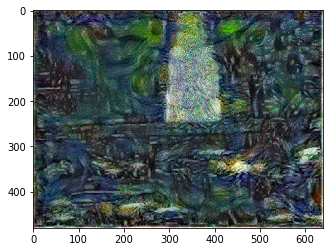

In [0]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(best_img, cv2.COLOR_BGR2RGB))

In [0]:
cv2.imwrite('./neural_style_transfer/saigonV2_2.jpg',best_img)

True